# [📖 Main Menu](index.html)

In [1]:
using StatsBase, DataFrames, DataFrameMacros
using RCall, CategoricalArrays, TexTables
using Distributions, Gadfly, Compose, MLJ
using DifferentialEquations

In [2]:
include("pubh.jl")
set_default_plot_size(15cm, 12cm)

# Lotka-Volterra

## Model

We start by defining a function, which depends on the vector of variables `u`, parameters `p` and time `t`.

$$
\begin{gather}
\frac{dx}{dt} = \alpha x - \beta xy \\
\frac{dy}{dt} = \gamma xy - \delta y
\end{gather}
$$

In [3]:
function lotka!(du, u, p, t)
  x, y = u
  α, β, γ, δ = p
  du[1] = dx = α*x  - β*x*y
  du[2] = dy = γ*x*y - δ*y
end;

## Parameters

We specify the value of the parameters, the initial conditions and the time span.

In [4]:
lotka_p = (α = 0.1, β = 0.005/60, γ = 4e-5, δ = 0.04)
lotka_u0 = [200, 600]
lotka_tspan = (0.0, 360.0);

## Simulation

In [5]:
lotka_prob = ODEProblem(lotka!, lotka_u0, lotka_tspan, lotka_p)
lotka_sol = solve(lotka_prob, reltol=1e-8, abstol=1e-8);

We find the vector with times in `.t`:

In [6]:
lotka_sol.t[1:5]

5-element Vector{Float64}:
 0.0
 0.0586667239835466
 0.44455978187816814
 1.8891760628783596
 4.153685732615579

The matrix for the solutions is in `.u`:

In [7]:
lotka_sol.u[1:5, :]

5×1 Matrix{Vector{Float64}}:
 [200.0, 600.0]
 [200.58808035146404, 598.8750684557691]
 [204.52749633793158, 591.5485461681885]
 [220.4238634692671, 565.2273087024415]
 [249.37964061408758, 527.3610714874475]

### Visualisation

In [8]:
lotka_df = DataFrame(lotka_sol)
rename!(
  lotka_df,
  :value1 => :Prey,
  :value2 => :Predator
)
lotka_melt = stack(lotka_df, Not(:timestamp))
lotka_melt |> head

Row,timestamp,variable,value
,Float64,String,Float64
1,0.0,Prey,200.0
2,0.0586667,Prey,200.588
3,0.44456,Prey,204.527
4,1.88918,Prey,220.424
5,4.15369,Prey,249.38


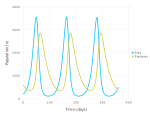

In [9]:
#| label: fig-fig1
#| fig-cap: "Dynamics of Lotka-Volterra model about prey-predator interactions. Example by constructing a data frame."
plot(
  lotka_melt,
  x=:timestamp, y=:value, color=:variable,
  Geom.path, style(line_width=0.7mm),
  Guide.xlabel("Time (days)"),
  Guide.ylabel("Population (n)"),
  Guide.colorkey("")
)

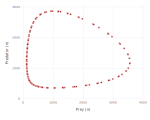

In [10]:
#| label: fig-fig3
#| fig-cap: "Prey-predator model showing cyclic interactions."
plot(
  lotka_df,
  x=:Prey, y=:Predator,
  Geom.point,
  Guide.xlabel("Prey (n)"),
  Guide.ylabel("Predator (n)"),
  Theme(default_color="FireBrick")
)

# Kermack and McKendrick

## Model

$$
\begin{eqnarray}
\frac{dS}{dt} &=& -\beta IS \\
\frac{dI}{dt} &=& \beta IS - \gamma I \\
\frac{dR}{dt} &=& \gamma I
\end{eqnarray}
$$

In [11]:
function sir!(du, u, p, t)
  S, I, R = u
  β, γ = p
  du[1] = dS = - β*I*S 
  du[2] = dI = β*I*S - γ*I
  du[3] = dR = γ*I
end;

## Parameters

In [12]:
sir_p = (β = 0.01, γ = 1/8)
sir_u0 = [200, 1, 0]
sir_tspan = (0.0, 90.0);

## Simulation

In [13]:
sir_prob = ODEProblem(sir!, sir_u0, sir_tspan, sir_p)
sir_sol = solve(sir_prob);

## Visualisation

In [14]:
sir_df = DataFrame(sir_sol)
rename!(
  sir_df,
  :value1 => :Susceptibles,
  :value2 => :Infectious,
  :value3 => :Recovered
)
sir_melt = stack(sir_df, Not(:timestamp))
sir_melt |> head

Row,timestamp,variable,value
,Float64,String,Float64
1,0.0,Susceptibles,200.0
2,0.0113068,Susceptibles,199.977
3,0.0669131,Susceptibles,199.857
4,0.176169,Susceptibles,199.583
5,0.328222,Susceptibles,199.095


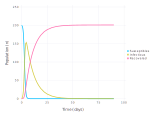

In [15]:
#| label: fig-fig4
#| fig-cap: "Dynamics of SIR model."
plot(
  sir_melt,
  x=:timestamp, y=:value, color=:variable,
  Geom.path, style(line_width=0.7mm),
  Guide.xlabel("Time (days)"),
  Guide.ylabel("Population (n)"),
  Guide.colorkey("")
)

# HIV multi-compartmental model

## Model

$$
S = e^{-\delta_1 t} + \frac{1}{\gamma} e^{-\delta_2 t}
$$

$$
\begin{eqnarray}
\frac{dV_b}{dt} &=& k_{lb} V_b - c_b V_b \\
\frac{dV_l}{dt} &=& S - k_{lf} Vl + k_{fl} V_f - c_l V_l \\
\frac{dV_f}{dt} &=& k_{lf} V_l - k_{fl} V_f
\end{eqnarray}
$$

In [16]:
function sl!(δ, γ, t)
  exp(-δ*t) + (1/γ) * exp(-0.001*t)
end;

In [17]:
function hiv!(du, u, p, t)
  Vb, Vl, Vf = u
  klb, klf, cl, cb, kfl, δ, γ = p
  du[1] = dVb = klb*Vl - cb*Vb
  du[2] = dVl = sl!(δ, γ, t) - klf*Vl + kfl*Vf - cl*Vl
  du[3] = klf*Vl - kfl*Vf
end;

## Parameters

In [18]:
hiv_p = (klb=0.5, klf=0.033, cl=3, cb=4.4, kfl=0.21, δ=0.44, γ=50)
hiv_u0 = [1, 20, 80]
hiv_tspan = (0.0, 2.0);

## Simulation

In [19]:
hiv_prob = ODEProblem(hiv!, hiv_u0, hiv_tspan, hiv_p)
hiv_sol = solve(hiv_prob, reltol=1e-8, abstol=1e-8);

## Visualisation

In [20]:
hiv_df = DataFrame(hiv_sol)
rename!(
  hiv_df,
  :value1 => :Vb,
  :value2 => :Vlt,
  :value3 => :Vfdc
)
hiv_melt = stack(hiv_df, Not(:timestamp))
hiv_melt |> head

Row,timestamp,variable,value
,Float64,String,Float64
1,0.0,Vb,1.0
2,0.0256363,Vb,1.12915
3,0.0552022,Vb,1.2459
4,0.0893782,Vb,1.34484
5,0.127504,Vb,1.41811


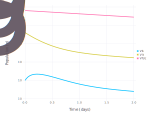

In [21]:
#| label: fig-fig2
#| fig-cap: "Dynamics of HIV-1 in different compartments"
plot(
  hiv_melt,
  x=:timestamp, y=:value, color=:variable,
  Geom.path, style(line_width=0.7mm),
  Guide.xlabel("Time (days)"),
  Guide.ylabel("Population (n)"),
  Guide.colorkey(""),
  Scale.y_log10
)

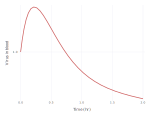

In [22]:
#| label: fig-fig5
#| fig-cap: "Dynamics of viral load in blood after chemotherapy."
plot(
  hiv_df,
  x=:timestamp, y=:Vb,
  Geom.path,
  Guide.xlabel("Time (hr)"),
  Guide.ylabel("Virus in blood"),
  Coord.cartesian(ymin=minimum(hiv_df.Vb)),
  Theme(default_color="IndianRed", line_width=0.7mm)
)

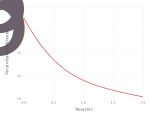

In [23]:
#| label: fig-fig6
#| fig-cap: "Dynamics of viral load in lymphoid tissue after chemotherapy."
plot(
  hiv_df,
  x=:timestamp, y=:Vlt,
  Geom.path, Scale.y_log10,
  Guide.xlabel("Time (hr)"),
  Guide.ylabel("Virus in lymphoid tissue"),
  Theme(default_color="IndianRed", line_width=0.7mm)
)

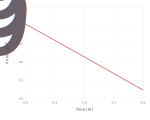

In [24]:
#| label: fig-fig7
#| fig-cap: "Dynamics of viral load in follicular dendritic cells after chemotherapy."
plot(
  hiv_df,
  x=:timestamp, y=:Vfdc,
  Geom.path, Scale.y_log10,
  Guide.xlabel("Time (hr)"),
  Guide.ylabel("Virus in FDC"),
  Theme(default_color="IndianRed", line_width=0.7mm)
)